### PART 2: Fan Base Prediction
#### subpart: min_df=2 with SVD dimensionality reduction technique(50 components)

In [1]:
import os
import json
import datetime
import time
import pytz
from collections import OrderedDict
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.api as sm
import numpy as np
from sklearn import metrics
from math import sqrt
import re
import emoji
import sklearn.preprocessing
from sklearn.feature_selection import f_regression
from sklearn.feature_selection import mutual_info_regression
from sklearn.feature_selection import SelectKBest
import os
import json
import datetime
import time
import pytz
from collections import OrderedDict
import matplotlib.pyplot as plt

import codecs
import re

/anaconda/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [3]:
hashtagData = dict()


pst_tz = pytz.timezone('US/Pacific')
oneHr = datetime.timedelta(minutes=60)
nflNumTweets = None
superbowlNumTweets = None

in_dir = '/Users/nikhilthakur/Downloads/tweet_small'

for root, dirs, files in os.walk(in_dir):
    path = root.split(os.sep)
    dateObj = None
    for f in files:
        fullPath = "/".join(path) + "/" + f
        print(fullPath)
        hashtag = f[8: -4]
        print("\n\n", hashtag)
        
        fh = open(fullPath, 'r')
            
        dfRowObjs = []
        for line in fh.readlines():
            jsonObject = json.loads(line)
            
            title = jsonObject['title']
            location = jsonObject['tweet']['user']['location']
            
            dfRowObj = {"title": title, "location": location}
            
            dfRowObjs.append(dfRowObj)

        df = pd.DataFrame(dfRowObjs)
        
        hashtagData[hashtag] = df

/Users/nikhilthakur/Downloads/tweet_small/tweets_#superbowl.txt
('\n\n', 'superbowl')


In [4]:
print(len(hashtagData["superbowl"]))

1348767


In [5]:
wa_regex1 = re.compile('seattle|washington', re.IGNORECASE)
wa_regex2 = re.compile('WA')
wa_regex3 = re.compile('dc|d.c.', re.IGNORECASE)
ma_regex1 = re.compile('boston|massachusetts', re.IGNORECASE)
ma_regex2 = re.compile('MA')

def getLabel(location):    
    if not wa_regex3.search(location) and (wa_regex1.search(location) or wa_regex2.search(location)):
        return 0
    if ma_regex1.search(location) or ma_regex2.search(location):
        return 1
    return -1
        

In [6]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold
from math import sqrt
from sklearn.metrics import mean_squared_error
import sys
from sklearn.preprocessing import PolynomialFeatures
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import svm

from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix
import itertools
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


def getClassifyModel(modelName, arg=None):
    model = None
    if modelName == 'SVM':
        model = svm.SVC(kernel='linear', C=arg[0], probability=True)
    
    if modelName == 'KNeighborsClassifier':
        model = KNeighborsClassifier(n_neighbors=arg[0])
  
    if modelName == 'RandomForestClassifier':
        model = RandomForestClassifier(n_estimators=arg[0], max_depth=arg[1], max_features=arg[2], oob_score=True, random_state=0)
    
    if modelName == 'DecisionTreeClassifier':
        model = DecisionTreeClassifier(max_features=arg[0])
 
    return model


def classifyKFold(modelName, args, X, y):
      
    kf = KFold(n_splits=5, shuffle=True)
    
    ftestAccuracy = list()

    
    for train_index, test_index in kf.split(X):
            
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        model = getClassifyModel(modelName, arg=args)

        model.fit(X_train, y_train)
        
        predictionTest = model.predict(X_test)
        
        acc = accuracy_score(y_test, predictionTest)

        
        ftestAccuracy.append(acc)

  
    testAccuracy = sum(ftestAccuracy) / len(ftestAccuracy)

    return testAccuracy

def classify(modelName, args, X, y, verbose=True, plot_roc=True):
    kf = KFold(n_splits=10, shuffle=True)
    
    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        model = getClassifyModel(modelName, arg=args)

        model.fit(X_train, y_train)
        
        predictionTest = model.predict(X_test)
        probaPredictionTest = model.predict_proba(X_test)
        
        accuracy = accuracy_score(y_test, predictionTest)
        precision = precision_score(y_test, predictionTest)
        recall = recall_score(y_test, predictionTest)
        f1 = f1_score(y_test, predictionTest)        
        break

    if verbose:
        print("Accuracy: " + str(accuracy))
        print("Precision: " + str(precision))
        print("Recall: " + str(recall))
        print("F1 score: " + str(f1))
    
        cnf_matrix = confusion_matrix(y_test, predictionTest)
        class_names = ['Washington','Massachusetts']
        plt.figure()
        plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=False,
                          title='Confusion matrix')

        plt.show()
        
    if plot_roc is True:
        fpr, tpr, thresholds = roc_curve(y_test, probaPredictionTest[:,1])
        roc_auc = auc(fpr, tpr)

        plt.title('Receiver Operating Characteristic')
        plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
        plt.legend(loc = 'lower right')
        plt.plot([0, 1], [0, 1],'r--')
        plt.xlim([0, 1])
        plt.ylim([0, 1])
        plt.ylabel('True Positive Rate')
        plt.xlabel('False Positive Rate')
        plt.show()


    return None

In [7]:
import re
from nltk.tokenize import TreebankWordTokenizer
from nltk.stem import wordnet
from nltk.stem.snowball import SnowballStemmer

toker = TreebankWordTokenizer()
lemmer = wordnet.WordNetLemmatizer()
stemmer = SnowballStemmer("english", ignore_stopwords=True)

def cleanDocuments(documents):
    cleanData = []

    for cleanDoc in documents:
        cleanDoc = re.sub(r"[\w\.-]+@[\w\.-]+", "", cleanDoc)
        cleanDoc = re.sub(r"-", " ", cleanDoc)
        cleanDoc = re.sub(r"[^A-z\s]", "", cleanDoc)
        cleanDoc = re.sub(r"_+", "", cleanDoc)
        cleanDoc = re.sub('\s+',' ', cleanDoc)

        cleanDoc = toker.tokenize(cleanDoc)
        cleanDoc = " ".join([lemmer.lemmatize(z) for z in cleanDoc])
        cleanDoc = stemmer.stem(cleanDoc)
        cleanData.append(cleanDoc)

    return cleanData

In [8]:
for hashtag in hashtagData:
    
    print("\nHashtag: ", hashtag)
    df = hashtagData[hashtag]
    
    labels = list()
    data = list()
    
    for index, tweet in df.iterrows():
        label = getLabel(tweet['location'])
        if label == -1:
            continue
        else:
            labels.append(label)

        # data extraction
        tweetText = tweet['title']

        data.append(tweetText)
    
    print("nFeatures: ", len(data))
    print("nLabel: ", len(labels))
    temp_y = np.array(labels)
    print("Wash: ", len(np.where(temp_y == 0)[0]))
    print("Mass: ", len(np.where(temp_y == 1)[0]))
        
y = np.array(labels)

print("\nTotal Data: ", len(data))
print("Total Labels: ", len(labels))
print("Total Wash(0): ", len(np.where(y == 0)[0]))
print("Total Mass(1): ", len(np.where(y == 1)[0]))

('\nHashtag: ', 'superbowl')
('nFeatures: ', 45574)
('nLabel: ', 45574)
('Wash: ', 20984)
('Mass: ', 24590)
('\nTotal Data: ', 45574)
('Total Labels: ', 45574)
('Total Wash(0): ', 20984)
('Total Mass(1): ', 24590)


In [9]:
def extractFeatures(data, minDf=2, is_svd=1, nComp=50):
    cleanData = cleanDocuments(data)

    from sklearn.feature_extraction.text import CountVectorizer

    vectorizer = CountVectorizer(min_df=minDf, stop_words = 'english')
    X_counts = vectorizer.fit_transform(cleanData)

    print(X_counts.shape)

    from sklearn.feature_extraction.text import TfidfTransformer
    tfidf_transformer = TfidfTransformer()

    X_tfidf = tfidf_transformer.fit_transform(X_counts)
    print(X_tfidf.shape)

    from sklearn.decomposition import TruncatedSVD
    from sklearn.decomposition import NMF


    if is_svd:
        svd = TruncatedSVD(n_components=nComp)
        X_reduced = svd.fit_transform(X_tfidf)
    else:
        nmf_model = NMF(n_components=nComp, init='random', random_state=0)
        X_reduced = nmf_model.fit_transform(X_tfidf)

    print(X_reduced.shape)

    X = np.array(X_reduced)
    return X


min_df=2, SVD with 50 Components

In [33]:
X = extractFeatures(data, 2, 1, 50)

(45574, 13312)
(45574, 13312)
(45574, 50)


In [35]:
print("\n\nModel 1: DecisionTreeClassifier Finding best args")
max_features = list(range(1,51,2))

bestAccuracy=0
bestArgs = [0]

for c in max_features:
    args = [c]
    print(args)
    currentAccuracy = classifyKFold('DecisionTreeClassifier', args, X, y)
    if currentAccuracy > bestAccuracy:
        bestAccuracy = currentAccuracy
        bestArgs = args
        
print("Best Accuracy: ", bestAccuracy)
print("Best Args: ", bestArgs)




Model 1: DecisionTreeClassifier Finding best args
[1]
[3]
[5]
[7]
[9]
[11]
[13]
[15]
[17]
[19]
[21]
[23]
[25]
[27]
[29]
[31]
[33]
[35]
[37]
[39]
[41]
[43]
[45]
[47]
[49]
('Best Accuracy: ', 0.7274322240707725)
('Best Args: ', [45])




Model 1: DecisionTreeClassifier
Accuracy: 0.726634488810882
Precision: 0.7537832310838446
Recall: 0.7410534780860475
F1 score: 0.7473641524736415
Confusion matrix, without normalization
[[1469  602]
 [ 644 1843]]


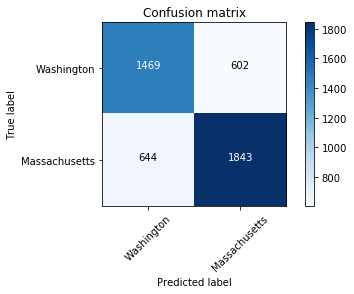

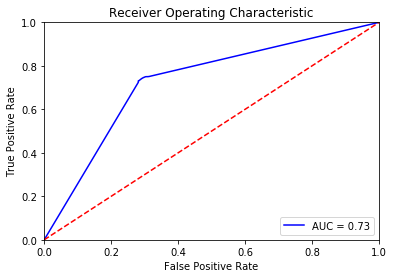

In [36]:
print("\n\nModel 1: DecisionTreeClassifier")
args = bestArgs
_ = classify('DecisionTreeClassifier', args, X, y)


In [28]:
print("\n\nModel 2: Random Forest Finding best args")
n_estimators = list(range(1,21,3))
max_features = list(range(1,51,4))

bestAccuracy=0
bestArgs = [0, None, 0]

for ne in n_estimators:
    for mf in max_features:
        args = [ne, None, mf]
        currentAccuracy = classifyKFold('RandomForestClassifier', args, X, y)
        if currentAccuracy > bestAccuracy:
            bestAccuracy = currentAccuracy
            bestArgs = args
            print("Best Accuracy: ", bestAccuracy)
            print("Best Args: ", bestArgs)

print("Best Accuracy: ", bestAccuracy)
print("Best Args: ", bestArgs)



Model 2: Random Forest Finding best args
('Best Accuracy: ', 0.6715234216773434)
('Best Args: ', [1, None, 1])
('Best Accuracy: ', 0.7057754648229154)
('Best Args: ', [1, None, 5])
('Best Accuracy: ', 0.7183919177707712)
('Best Args: ', [1, None, 9])
('Best Accuracy: ', 0.7207398237549579)
('Best Args: ', [1, None, 37])
('Best Accuracy: ', 0.7233512438472107)
('Best Args: ', [4, None, 5])
('Best Accuracy: ', 0.7286389803032497)
('Best Args: ', [4, None, 9])
('Best Accuracy: ', 0.7312064348327054)
('Best Args: ', [4, None, 13])
('Best Accuracy: ', 0.731491575413808)
('Best Args: ', [4, None, 25])
('Best Accuracy: ', 0.7330494518689397)
('Best Args: ', [4, None, 33])
('Best Accuracy: ', 0.7371746528491248)
('Best Args: ', [7, None, 1])
('Best Accuracy: ', 0.7568351006107679)
('Best Args: ', [7, None, 5])
('Best Accuracy: ', 0.7572081867623981)
('Best Args: ', [7, None, 9])
('Best Accuracy: ', 0.7603677174513214)
('Best Args: ', [7, None, 13])
('Best Accuracy: ', 0.7609602438112187)
('B



Model 2
Accuracy: 0.7720491443615621
Precision: 0.7669902912621359
Recall: 0.8319157553665452
F1 score: 0.7981348358266952
Confusion matrix, without normalization
[[1465  624]
 [ 415 2054]]


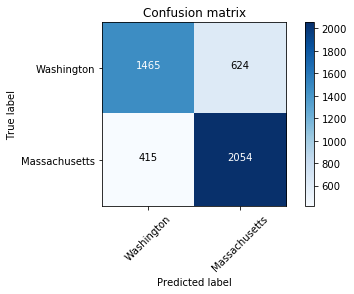

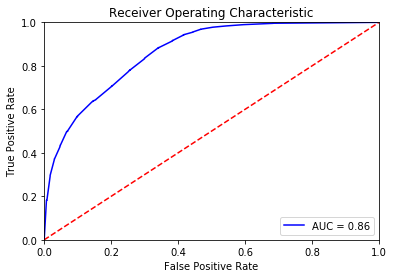

In [29]:
print("\n\nModel 2")
args = bestArgs
_ = classify('RandomForestClassifier', args, X, y)


In [30]:
print("\n\nModel 3: KNN Finding best args")
nnrange = list(range(1,50,2))

bestAccuracy=0
bestArgs = [0]

for nn in nnrange:
    args = [nn]
    print(args)
    currentAccuracy = classifyKFold('KNeighborsClassifier', args, X, y)
    if currentAccuracy > bestAccuracy:
        bestAccuracy = currentAccuracy
        bestArgs[0] = args[0]
        
print("Best Accuracy: ", bestAccuracy)
print("Best Args: ", bestArgs)




Model 3: KNN Finding best args
[1]
[3]
[5]
[7]
[9]
[11]
[13]
[15]
[17]
[19]
[21]
[23]
[25]
[27]
[29]
[31]
[33]
[35]
[37]
[39]
[41]
[43]
[45]
[47]
[49]
('Best Accuracy: ', 0.7619258370628346)
('Best Args: ', [35])




Model 3: KNN
Accuracy: 0.7597630539710399
Precision: 0.7196870925684485
Recall: 0.9038067949242734
F1 score: 0.8013064779531845
Confusion matrix, without normalization
[[1255  860]
 [ 235 2208]]


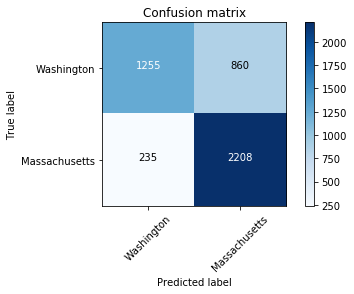

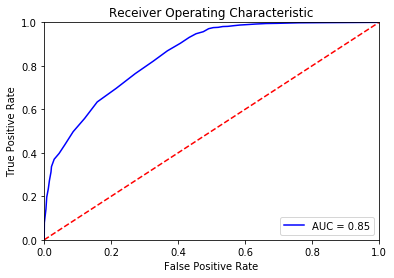

In [31]:
print("\n\nModel 3: KNN")
args = bestArgs
_ = classify('KNeighborsClassifier', args, X, y)

#### END OF NOTEBOOK